# PyTorch Computer Vision

## 0. Computer Vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch Computer Vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

First, we import the necessary modules

In [1]:
import torch 
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

#Check versions
print(torch.__version__)
print(torchvision.__version__)

2.7.0
0.22.0


In [2]:
# Make device agnostic code
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


## 1. Getting a dataset

The dataset we'll be using is the `FashionMNIST`

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(root="data",     # where to download data to
                                   train=True,      # do we want training dataset?
                                   download=True,   # do we want to download?
                                   transform=ToTensor(),
                                   target_transform=None)
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

60000 train images and 100000 test images

In [5]:
image,label = train_data[0]
image,label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Check input and output shapes of the data

In [8]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]


### 1.2 Visualize our data

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

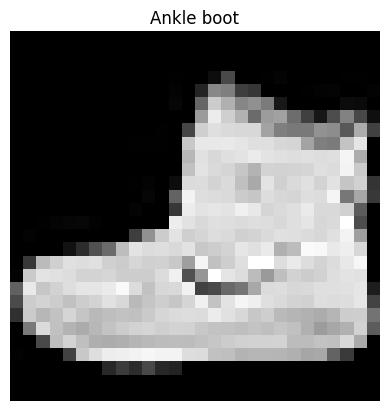

In [9]:
import matplotlib.pyplot as plt

image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")     # remove the singular dimension
plt.title(class_names[label])
plt.axis(False)

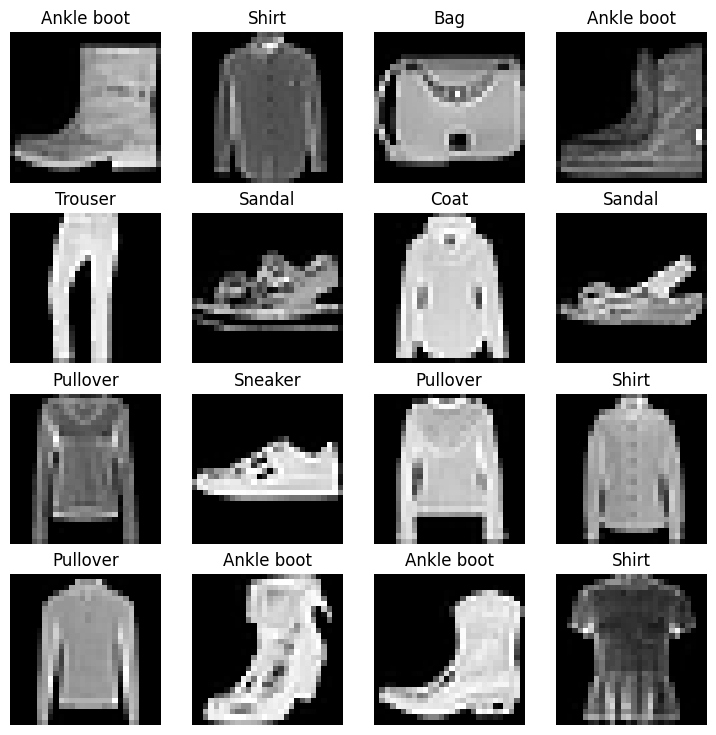

In [10]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4 
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [11]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets. DataLoader turns our dataset into a Python iterable. More specifically, we want to turn our data into batches (or mini-batches). Why would we do this?

1. It is more computationally efficient, as in your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time.
2. It gives our neural network more chances to update its gradients per epoch.

In [12]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32 

# Turnd atasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x158582fa0>,
 <torch.utils.data.dataloader.DataLoader at 0x151c772b0>)

In [13]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [14]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

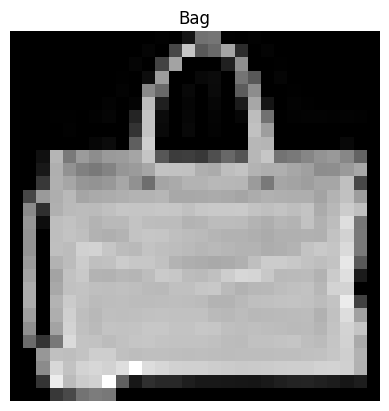

In [15]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="grey")
plt.title(class_names[label])
plt.axis(False)

## 3. Model 0: Building a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: Start simply and add complexity when necessary.

In [16]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x= train_features_batch[0]

# Flatten the sample 
output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"shape after flattening: {output.shape}")



Shape before flattening: torch.Size([1, 28, 28])
shape after flattening: torch.Size([1, 784])


In [17]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
    
torch.manual_seed(42)
model0 = FashionMNISTModelV0(input_shape=784,
                             hidden_units=10,
                             output_shape=len(class_names))

In [18]:
dummy_x = torch.rand([1,1,28,28])
model0(dummy_x).shape

torch.Size([1, 10])

One logit for each class!

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're workung with multi-class data, our loss funciton will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer is `torch.optim.SGD()` 
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric

In [19]:
from helpers import accuracy_fn

# Setup loss function an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

/Users/mhehl/Documents/PyTorch - Course/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 3.2 Creating a function to time our experiments

Machine learning is very experimental. Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy)
2. How fast it runs.

There is often a trade-off between the two.

In [20]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time

    Args:
        start (float): start time
        end (float): end time
        device (torch.device, optional): device. Defaults to None.
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [21]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


8.166999999836833e-06

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loos *per batch*.
4. Print out waht's happening.
5. Time it all (for fun).

In [22]:
# Import tqdm for a progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n -------")
    ###Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model0.train()
        # 1. Forward pass
        y_logits = model0(X)

        # 2. Calculate the loss (per batch)
        loss = loss_fn(y_logits, y)
        train_loss += loss      # accumulate train loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backward pass
        loss.backward()

        # 5. Optimizer step
        optimizer.step()        # Updating the weights once per batch!!!

        # Print out what's happening 
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")
    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing 
    test_loss, test_acc = 0,0
    model0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_logits = model0(X_test)
            # 2. Calculate the loss
            test_loss += loss_fn(test_logits, y_test)
            # 3. Calculate the accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_logits.argmax(dim=1))
        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)
    # Print out what's happening
    print(f"\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model0.parameters()).device))


/Users/mhehl/Documents/PyTorch - Course/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
 -------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]


 Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.0387
Epoch: 1 
 -------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]


 Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.1969
Epoch: 2 
 -------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


 Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.4265
Train time on cpu: 4.932 seconds


## 4. Make predictions and get Model results

In [23]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device=device):
    """Returns a dictionary containing the results of model predicting on data loader

    Args:
        model (torch.nn.Module): model
        data_loader (torch.utils.data.DataLoader): data loader
        loss_fn (torch.nn.Module): loss function
        accuracy_fn (_type_): accuracy function
    """
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            # Make our data device agnostic
            X,y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)
            # Accumulate loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        # Scale the loss and acc to find the average per batch:
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,     # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model0_results = eval_model(model=model0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device="cpu")
model0_results


100%|██████████| 313/313 [00:00<00:00, 1547.57it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic code (for using a GPU if there is one)

In [24]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


## 6. Model 1: Building a better model with non-linearity

In [25]:
# Create a model with non-linear functions running on the CPU

class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
    


In [26]:
# Create an instance of Model1
torch.manual_seed(42)
model1 = FashionMNISTModelV1(input_shape=784,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device=device)
model1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [27]:
next(model1.parameters()).device

device(type='mps', index=0)

### 6.1 Setup loss, optimizer and evaluation metrics

In [28]:
from helpers import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

### 6.2 Functionizing training an evaluation/testing loops

Let's create functions for 
* Training loop - `train_step()`
* Testing loop - `test_step()`

In [29]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device=device):
    """Performs a training step with model trying to learn on data_loader.

    Args:
        model (torch.nn.Module): model
        data_loader (torch.utils.data.DataLoader): data loader
        loss_fn (torch.nn.Module): loss function
        optimizer (torch.optim.Optimizer): optimizer
        accuracy_fn (_type_): accuracy function
        device (torch.device, optional): Device. Defaults to device.
    """
    train_loss, train_acc = 0, 0
    # Put model into training mode
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
        y_logits = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_logits.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step (upodate the model's parameters once per batch)
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f} % ")



In [30]:
def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              accuracy_fn,
              device: torch.device=device):
    """Performs a testing loop step on model going over data_loader

    Args:
        model (torch.nn.Module): model
        data_loader (torch.utils.data.DataLoader): test data loader
        loss_fn (torch.nn.Module): loss function
        accuracy_fn (_type_): accuracy function
        device (torch.device, optional): device. Defaults to device.
    """

    test_loss, test_acc = 0,0
    # Put the model in eval mode
    model.eval()
    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to target device
            X,y = X.to(device), y.to(device)

            # 1. Forward pass
            y_logits = model(X)

            # 2. Calculate the loss/accurracy
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=y_logits.argmax(dim=1))
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.3f}%")
            

In [31]:
torch.manual_seed(42)

# measure time 
train_time_start_on_gpu = timer()

# Set epochs 
epochs=3

# Create a optimization and evaluation loop using our functions
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=model1, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_step(model=model1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)


train_time_end_on_gpu = timer()

total_train_time_model1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.09199 | Train acc: 61.34 % 


 33%|███▎      | 1/3 [00:04<00:08,  4.35s/it]

Test loss: 0.95636 | Test acc: 64.996%
Epoch: 1
----------
Train loss: 0.78097 | Train acc: 71.94 % 


 67%|██████▋   | 2/3 [00:08<00:04,  4.17s/it]

Test loss: 0.72611 | Test acc: 73.992%
Epoch: 2
----------
Train loss: 0.67040 | Train acc: 75.94 % 


100%|██████████| 3/3 [00:12<00:00,  4.11s/it]

Test loss: 0.69007 | Test acc: 74.810%
Train time on mps: 12.331 seconds


**Note**: Sometimes, depending on your data/hardware you moght find that your model trains faster on CPU than GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.
2. The hardware you're using has a better CPU in terms of compute capability than the GPU.

In [32]:
model0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [33]:
model1_results = eval_model(model=model1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model1_results

100%|██████████| 313/313 [00:00<00:00, 651.46it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6900655031204224,
 'model_acc': 74.810303514377}

## 7. Model 2: Building a Convolutional Neural Network (CNNs)

CNNs are known for their capabilities to find patterns in visual data. 

In [34]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(x.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [35]:
torch.manual_seed(42)
# input_shape = Number of color channels in our images
# hidden_units = Number of channels the Convolutional neural networks give out
# output_shape = Number of classes
model2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device=device)

### 7.1 Stepping though `nn.Conv2d()`

See the documentation for `nn.Conv2d()`. 

In [36]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]
print(f"Image batch shape: {image.shape}")
print(f"Single image shape: {test_image.shape}")

Image batch shape: torch.Size([1, 28, 28])
Single image shape: torch.Size([3, 64, 64])


In [37]:
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=10,
                       kernel_size=(3,3),
                       stride=1,
                       padding=0)


# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

Playing around with this gives us a good feeling of how it works.

### 7.2 Stepping through `nn.MaxPool2D()`

In [38]:
print(f"Test image original shape: {test_image.shape}")

# Create a sample nn.MaxPool2d Layer
max_pool_layer = nn.MaxPool2d(kernel_size=(2,2))

# Pass data through the convolutional layer
test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv_layer: {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer and max_pool: {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Shape after going through conv_layer: torch.Size([10, 62, 62])
Shape after going through conv_layer and max_pool: torch.Size([10, 31, 31])


In [39]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(1,1,2,2)
print(f"\nRandom tensor: \n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass random rensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor: \n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor: 
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor: 
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


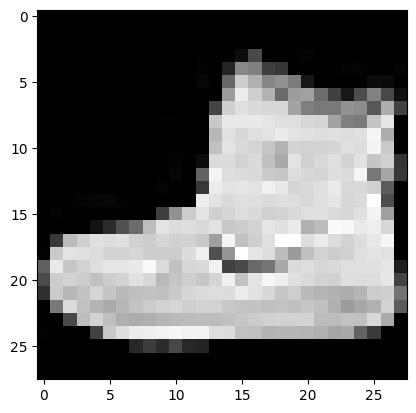

In [40]:
plt.imshow(image.squeeze(), cmap="gray")

### 7.3 Setup a loss function and optimizer for model2

In [41]:
from helpers import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

### 7.4 Training and testing model2

In [42]:
torch.manual_seed(42)

# Measure the time
from timeit import default_timer as timer
train_time_start_model2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-------")
    train_step(model=model2,
               data_loader=train_dataloader,
               loss_fn=loss_fn, 
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model2, 
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model2 = timer()
total_train_time_model2 = print_train_time(start=train_time_start_model2, end= train_time_end_model2, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-------
Train loss: 0.59166 | Train acc: 78.49 % 


 33%|███▎      | 1/3 [00:08<00:16,  8.16s/it]

Test loss: 0.39617 | Test acc: 85.723%
Epoch: 1 
-------
Train loss: 0.36768 | Train acc: 86.69 % 


 67%|██████▋   | 2/3 [00:16<00:08,  8.23s/it]

Test loss: 0.35426 | Test acc: 86.921%
Epoch: 2 
-------
Train loss: 0.32993 | Train acc: 87.92 % 


100%|██████████| 3/3 [00:24<00:00,  8.15s/it]

Test loss: 0.32604 | Test acc: 87.959%
Train time on mps: 24.436 seconds


In [43]:
model2_results = eval_model(model=model2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

100%|██████████| 313/313 [00:00<00:00, 593.55it/s]


In [44]:
print(model2_results)
print(model0_results)

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3260429799556732, 'model_acc': 87.95926517571885}
{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}


## 8. Compare model results and training time

In [45]:
import pandas as pd
compare_results = pd.DataFrame([model0_results, model1_results, model2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.690066,74.810304
2,FashionMNISTModelV2,0.326043,87.959265


In [46]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model0, total_train_time_model1, total_train_time_model2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,4.932157
1,FashionMNISTModelV1,0.690066,74.810304,12.330664
2,FashionMNISTModelV2,0.326043,87.959265,24.436386


Text(0, 0.5, 'model')

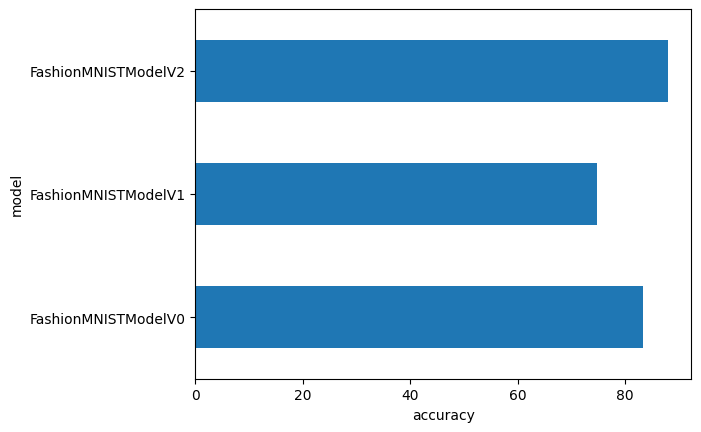

In [47]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("model")

## 9. Make and evaluate random predictions with best model

In [48]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
    pred_probs = []
    model.to(device=device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # prepare the sample
            sample = sample.unsqueeze(dim=0).to(device)

            pred_logit = model(sample)

            # Get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [49]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k =9):
    test_samples.append(sample)
    test_labels.append(label)
    

Text(0.5, 1.0, 'Sandal')

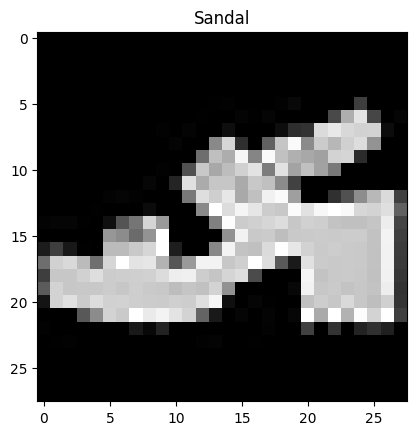

In [50]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [51]:
# Make predictions
pred_probs = make_predictions(model=model2, data= test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [52]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

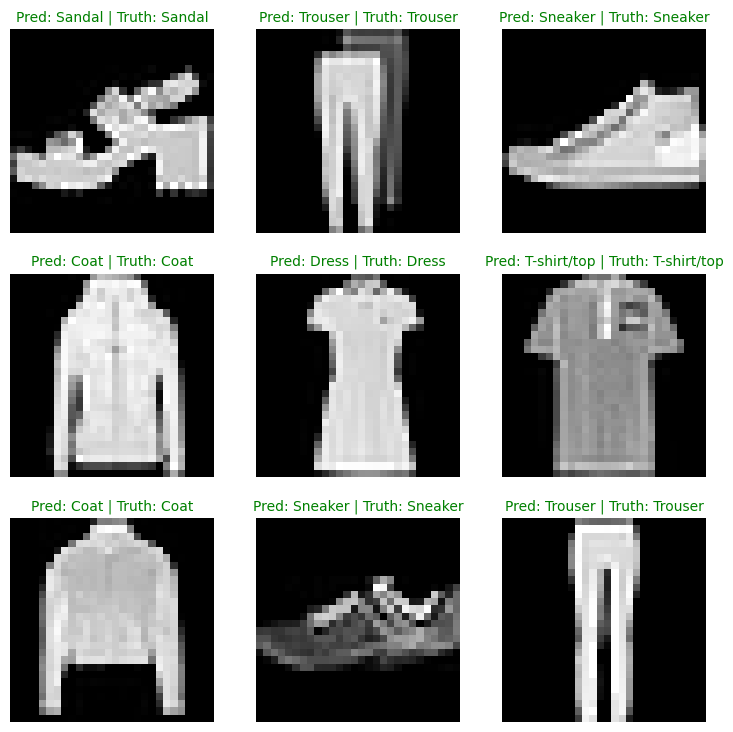

In [53]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i,sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows,ncols, i+1)
    
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction 
    pred_label = class_names[pred_classes[i]]

    # Get the true label
    true_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {true_label}"

    if pred_label == true_label:
        plt.title(title_text,fontsize=10,c="g")
    else:
        plt.title(title_text, fontsize=10,c="r")
    plt.axis(False)


## 10. Making a confusion matrix for further prediction evaluation
A confusion matrix is a great way of evaluating your classification models visually.

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix using `torchmetrics.ConfusionMatrix()`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [54]:
# 1. Make predictions with trained model
y_preds = []
model2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and targets to the target device
        X,y = X.to(device), y.to(device)
        y_logit = model2(X)
        y_pred = torch.argmax(y_logit, dim=1)
        # Put prediction on CPU
        y_preds.append(y_pred.cpu())

# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:40]

Making predictions...: 100%|██████████| 313/313 [00:00<00:00, 651.54it/s]


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 7, 7, 5,
        1, 2, 6, 0, 9, 4, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9])

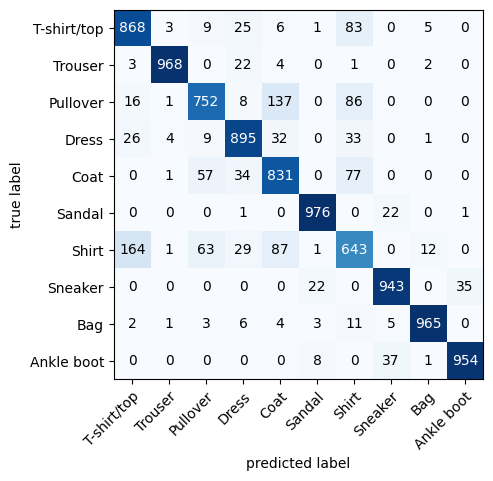

In [55]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets

confmat = ConfusionMatrix(task='multiclass', num_classes=10)
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# 3. Plot our confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names)

## 11. Save and load best performing model

In [56]:
from pathlib import Path

#Create model directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model2.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
MODEL_SAVE_PATH

# Save the model state dict
torch.save(obj=model2.state_dict(),f=MODEL_SAVE_PATH)

In [57]:
# Create a new instance
model_reloaded = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)

# Load in the save state_dict
model_reloaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

model_reloaded.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [58]:
# Evaluate the loaded model
model2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3260429799556732,
 'model_acc': 87.95926517571885}

In [59]:
model_reloaded_results=eval_model(model=model_reloaded, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_reloaded_results

100%|██████████| 313/313 [00:00<00:00, 547.64it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3260429799556732,
 'model_acc': 87.95926517571885}

Same results as above, so it worked!

In [60]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model2_results["model_loss"]), torch.tensor(model_reloaded_results["model_loss"]))

tensor(True)

## 12. Exercises

### 12.1 3 areas where computer vision is currently being used 

* Self-driving cars
* Health care, e.g., for cancer detection
* Military

### 12.2 What is overfitting in machine learning

Overfitting is when a model learns the training data too well, including its noise and anomalies, resulting in poor performance on new, unseen data.

### 12.3 Ways to prevent overfitting in machine learning

* L1/L2 Regularization - Adding a regularization term to the loss function
* Dropout - Randomly removing neurons in different layers
* Use a smaller model
* Early stopping - Stop training early

### 12.4 Read about CNNs

### 12.5 Load the torchvision.datasets.MNIST() train and test datasets.

In [61]:
train_data = torchvision.datasets.MNIST(root="data",
                                        train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

test_data = torchvision.datasets.MNIST(root="data", 
                                       train=False,
                                       download=True,
                                       transform=transforms.ToTensor())

### 12.6 Visualize at least 5 different samples of the MNIST training dataset.

In [62]:
test_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

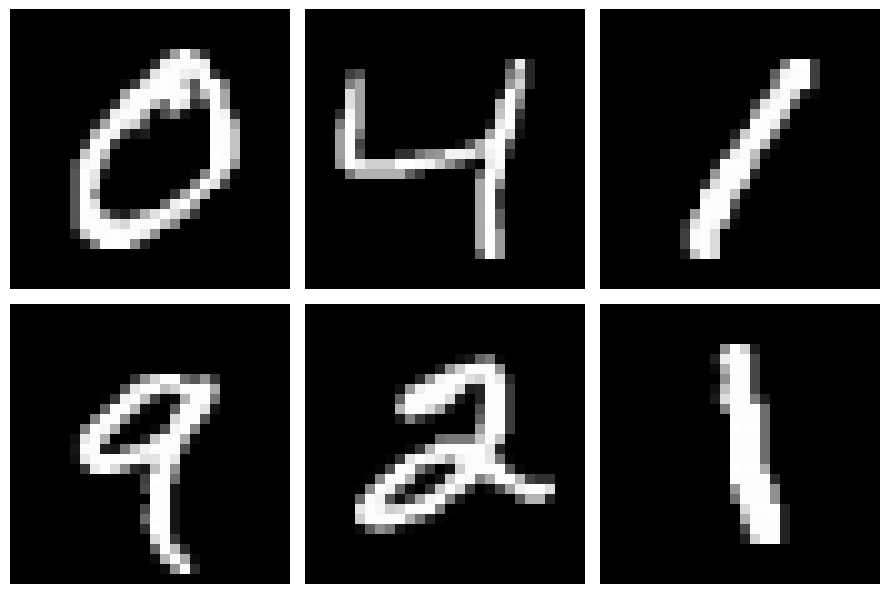

In [63]:
cols = 2
rows = 3
plt.figure(figsize=(9,9))
for i in range(1,7):
    # Create subplot
    plt.subplot(nrows,ncols, i)
    
    # Plot the target image
    plt.imshow(train_data.data[i].squeeze(), cmap="gray")
    plt.axis(False)
plt.tight_layout()

### 12.7 Turn the MNIST train and test datasets into dataloaders using

In [64]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

### 12.8 Recreate model_2 used in this notebook

In [65]:
model_exercise = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)

In [66]:
model_exercise

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 12.9 Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_exercise.parameters(), lr=0.1)

In [68]:
torch.manual_seed(42)
epochs = 3

### Train model on CPU
start_time_cpu = timer()
for epoch in range(epochs):
    print(f"Epoch:{epoch} \n-----------")
    train_step(model=model_exercise, 
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device="cpu")
    
    test_step(model=model_exercise,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device="cpu")
end_time_cpu = timer()
print_train_time(start=start_time_cpu, end=end_time_cpu, device="cpu")

Epoch:0 
-----------
Train loss: 0.35580 | Train acc: 87.72 % 
Test loss: 0.07623 | Test acc: 97.574%
Epoch:1 
-----------
Train loss: 0.07853 | Train acc: 97.56 % 
Test loss: 0.06204 | Test acc: 98.113%
Epoch:2 
-----------
Train loss: 0.06353 | Train acc: 98.03 % 
Test loss: 0.06131 | Test acc: 98.073%
Train time on cpu: 51.217 seconds


51.216524957999994

In [69]:
torch.manual_seed(42)
epochs = 3

# Train model on GPU
model_exercise = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)
model_exercise.to(device=device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_exercise.parameters(), lr=0.1)

start_time_gpu = timer()
for epoch in range(epochs):
    print(f"Epoch:{epoch} \n-----------")
    train_step(model=model_exercise, 
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_exercise,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
end_time_gpu = timer()
print_train_time(start=start_time_gpu, end=end_time_gpu, device=device)

Epoch:0 
-----------
Train loss: 0.26721 | Train acc: 91.23 % 
Test loss: 0.07273 | Test acc: 97.664%
Epoch:1 
-----------
Train loss: 0.06889 | Train acc: 97.81 % 
Test loss: 0.04171 | Test acc: 98.572%
Epoch:2 
-----------
Train loss: 0.05489 | Train acc: 98.28 % 
Test loss: 0.04590 | Test acc: 98.542%
Train time on mps: 24.398 seconds


24.398464542

More than twice as fast than on the CPU!

### 12.10 Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

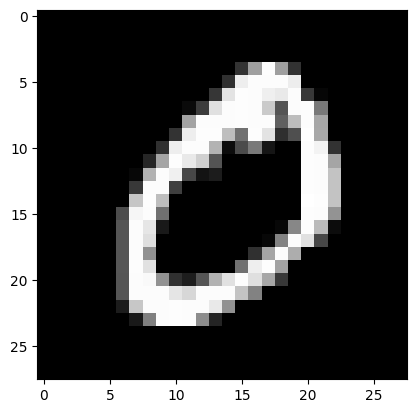

In [76]:
plt.imshow(train_data[1][0].squeeze(), cmap="gray")

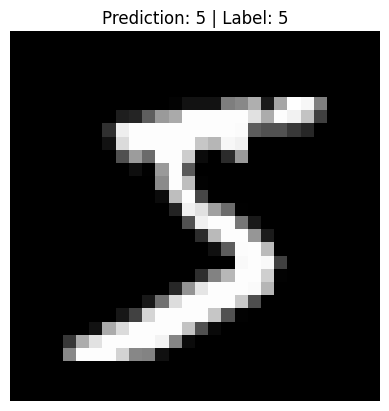

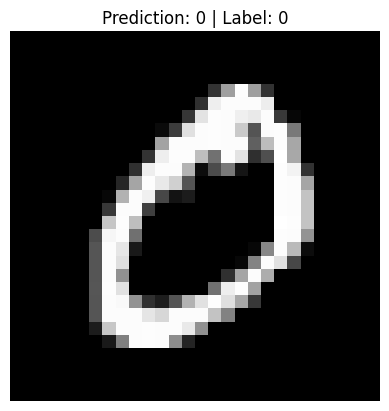

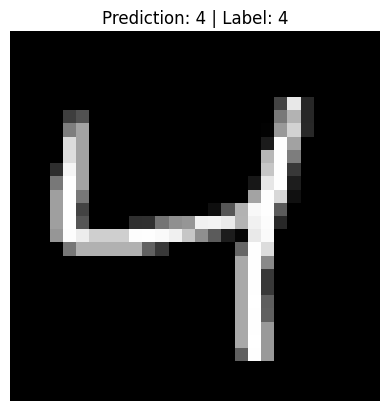

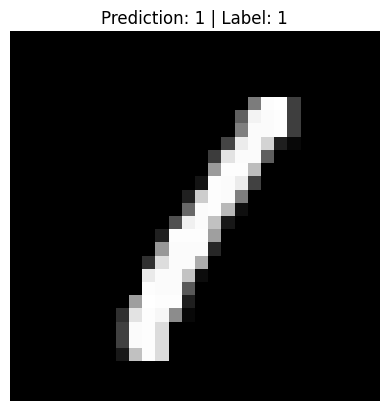

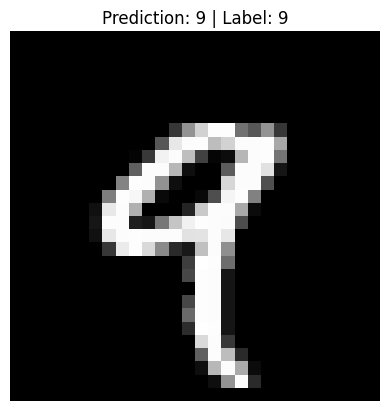

In [83]:
plots = 5

for i in range(plots):
    logits = model_exercise(train_data[i][0].unsqueeze(dim=0).to(device))
    pred = logits.argmax(dim=1)

    plt.figure()
    plt.imshow(train_data[i][0].squeeze(), cmap="gray")
    plt.title(f"Prediction: {int(pred)} | Label: {train_data[i][1]}")
    plt.axis(False)

### 12.11 Plot a confusion matrix comparing your model's predictions to the truth labels.

In [88]:
model_exercise.eval()
y_preds = []

with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(test_dataloader)):
        X, y = X.to(device), y.to(device)
   
        logits = model_exercise(X)
       
        y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        y_preds.append(y_pred)
    y_preds=torch.cat(y_preds).cpu()
len(y_preds)

313it [00:00, 661.17it/s]


10000

In [91]:
print(len(test_data.targets))
print(test_data.targets)
y_preds


10000
tensor([7, 2, 1,  ..., 4, 5, 6])


tensor([7, 2, 1,  ..., 4, 5, 6])

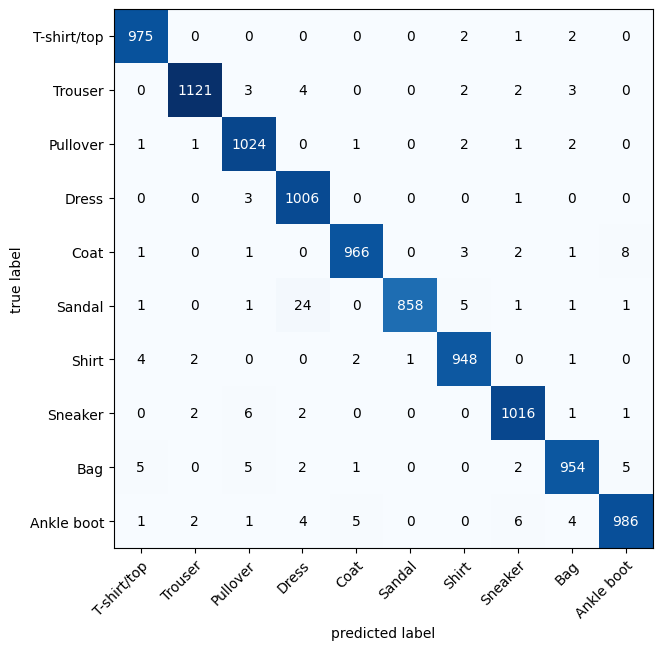

In [92]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix 
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

### 12.12 Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [87]:
random_tensor = torch.randn(size=(1,3,64,64))
f = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3,3), stride=1, padding=1)
f(random_tensor).shape

torch.Size([1, 2, 64, 64])